
# Actividad Individual No. 2

Fundamentos de Machine Learning e IA Aplicado a Redes

**Objetivo:** recorrer el **ciclo de vida completo** de un modelo de ML aplicado a **ciberseguridad de redes**, con ejemplos prácticos de:

- Clasificación de tráfico (multi-clase)
- Detección de intrusiones / IDS (binario)
- Métricas y validación
- Guardado y carga del modelo (deploy)
- Monitoreo básico / deriva (drift) con nuevas muestras

> **Nota:** El dataset se genera de forma sintética pero las *caracterisitcas* simulan flujos de red comunes: bytes por flujo, duración, paquetes, flags, ratios, etc.



## 1) Ciclo de vida de un modelo en ciberseguridad

1. **Definición del problema**: ¿Clasificar tráfico o detectar intrusiones?
2. **Datos**: recolección, limpieza, ingeniería de *features* (ej. estadísticos por flujo).
3. **Partición**: entrenamiento/validación/prueba.
4. **Entrenamiento**: selección de algoritmo y *tuning* simple.
5. **Evaluación**: métricas (Precision, Recall, F1, ROC-AUC, matriz de confusión).
6. **Despliegue**: guardar/cargar modelo; predicciones en línea por lote.
7. **Monitoreo**: detección de deriva (drift) y *retraining* cuando sea necesario.


In [1]:

# Imports
import numpy as np
import pandas as pd
from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score, roc_curve
import matplotlib.pyplot as plt
import joblib

# Config reproducibilidad
rng = np.random.default_rng(42)



## 2) Generación de datos sintéticos estilo *network flows*

Se crean variables que imitan estadísticas de flujos:
- `duration`, `bytes_fwd`, `bytes_bwd`, `pkts_fwd`, `pkts_bwd`
- `pkt_len_mean`, `pkt_len_std`, `fwd_bwd_ratio`, `psh_flag_cnt`, `urg_flag_cnt`

Realizan dos tareas:
- **Detección de intrusiones (binario)**: *benigno* vs *intrusión*.
- **Clasificación de tráfico (multiclase)**: *web*, *dns*, *ssh*, *malware*.


In [2]:

# Función auxiliar para crear caracterisicas con estructura de "flujo de red"
def synth_flows(n_samples, seed=0):
    rng = np.random.default_rng(seed)
    duration = rng.gamma(2.0, 0.8, n_samples)  # s
    bytes_fwd = rng.lognormal(8, 0.8, n_samples)
    bytes_bwd = rng.lognormal(7.5, 0.9, n_samples)
    pkts_fwd = (bytes_fwd / rng.lognormal(5.5, 0.6, n_samples)).astype(int).clip(1, None)
    pkts_bwd = (bytes_bwd / rng.lognormal(5.3, 0.6, n_samples)).astype(int).clip(1, None)
    pkt_len_mean = (bytes_fwd + bytes_bwd) / (pkts_fwd + pkts_bwd)
    pkt_len_std = pkt_len_mean * rng.uniform(0.05, 0.35, n_samples)
    fwd_bwd_ratio = (bytes_fwd + 1) / (bytes_bwd + 1)
    psh_flag_cnt = rng.poisson(0.2, n_samples)
    urg_flag_cnt = rng.poisson(0.05, n_samples)
    X = np.column_stack([
        duration, bytes_fwd, bytes_bwd, pkts_fwd, pkts_bwd,
        pkt_len_mean, pkt_len_std, fwd_bwd_ratio, psh_flag_cnt, urg_flag_cnt
    ])
    cols = ["duration","bytes_fwd","bytes_bwd","pkts_fwd","pkts_bwd",
            "pkt_len_mean","pkt_len_std","fwd_bwd_ratio","psh_flag_cnt","urg_flag_cnt"]
    return pd.DataFrame(X, columns=cols)

# Conjuntos por clase de tráfico
n = 2500
web = synth_flows(n, seed=1)
dns = synth_flows(n, seed=2)
ssh = synth_flows(n, seed=3)
malware = synth_flows(n, seed=4)

# Ajustes característicos por clase (solapamiento realista)
web["bytes_fwd"] *= 1.2; web["pkts_fwd"] *= 1.1
dns["duration"] *= 0.4; dns["pkt_len_mean"] *= 0.6; dns["pkts_fwd"] *= 1.4
ssh["duration"] *= 1.5; ssh["fwd_bwd_ratio"] *= 1.3
malware["bytes_bwd"] *= 1.6; malware["psh_flag_cnt"] += 1; malware["urg_flag_cnt"] += 1

# Etiquetas multi-clase
web["y_mc"] = 0; dns["y_mc"] = 1; ssh["y_mc"] = 2; malware["y_mc"] = 3
df_mc = pd.concat([web, dns, ssh, malware], ignore_index=True)

# Etiquetas binarias para IDS: 0 = benigno (web/dns/ssh), 1 = intrusión (malware)
df_bin = df_mc.copy()
df_bin["y_bin"] = (df_bin["y_mc"] == 3).astype(int)

df_mc.shape, df_bin.shape


((10000, 11), (10000, 12))


## 3) Entrenamiento y evaluación

Fase de entrenar los dos modelos:
- **Clasificación de tráfico (multiclase)** → `RandomForestClassifier`
- **Detección de intrusiones (binario)** → `LogisticRegression` dentro de `Pipeline` con `StandardScaler`

Usamos `train_test_split` y reportamos métricas.


In [3]:

# Columnas de features
features = ["duration","bytes_fwd","bytes_bwd","pkts_fwd","pkts_bwd",
            "pkt_len_mean","pkt_len_std","fwd_bwd_ratio","psh_flag_cnt","urg_flag_cnt"]

# ---- Multiclase (tráfico) ----
X_mc = df_mc[features].values
y_mc = df_mc["y_mc"].values
Xtr_mc, Xte_mc, ytr_mc, yte_mc = train_test_split(X_mc, y_mc, test_size=0.25, random_state=123, stratify=y_mc)

rf = RandomForestClassifier(n_estimators=160, random_state=123, n_jobs=-1)
rf.fit(Xtr_mc, ytr_mc)
pred_mc = rf.predict(Xte_mc)

print("== Clasificación de tráfico (multiclase) ==")
print(classification_report(yte_mc, pred_mc, digits=4))

# ---- Binario (IDS) ----
X_bin = df_bin[features].values
y_bin = df_bin["y_bin"].values
Xtr_b, Xte_b, ytr_b, yte_b = train_test_split(X_bin, y_bin, test_size=0.25, random_state=123, stratify=y_bin)

pipe = Pipeline([("scaler", StandardScaler()),
                 ("clf", LogisticRegression(max_iter=1000, n_jobs=None))])
pipe.fit(Xtr_b, ytr_b)
pred_b = pipe.predict(Xte_b)
proba_b = pipe.predict_proba(Xte_b)[:,1]

print("\n== Detección de intrusiones (binario) ==")
print(classification_report(yte_b, pred_b, digits=4))
print("ROC-AUC:", round(roc_auc_score(yte_b, proba_b), 4))


== Clasificación de tráfico (multiclase) ==
              precision    recall  f1-score   support

           0     0.6716    0.6544    0.6629       625
           1     0.7961    0.8496    0.8220       625
           2     0.7307    0.6816    0.7053       625
           3     0.9750    1.0000    0.9874       625

    accuracy                         0.7964      2500
   macro avg     0.7934    0.7964    0.7944      2500
weighted avg     0.7934    0.7964    0.7944      2500


== Detección de intrusiones (binario) ==
              precision    recall  f1-score   support

           0     1.0000    0.9856    0.9927      1875
           1     0.9586    1.0000    0.9789       625

    accuracy                         0.9892      2500
   macro avg     0.9793    0.9928    0.9858      2500
weighted avg     0.9896    0.9892    0.9893      2500

ROC-AUC: 0.9931



### 3.1) Matrices de confusión


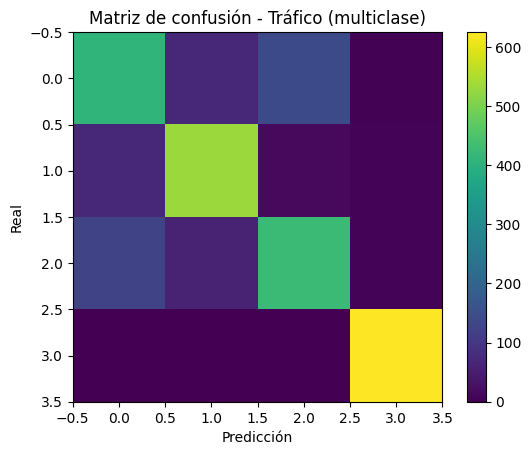

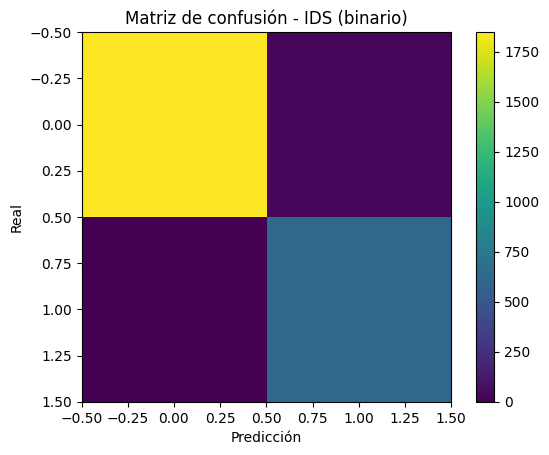

In [4]:

# Matriz de confusión multiclase
cm_mc = confusion_matrix(yte_mc, pred_mc)
plt.figure()
plt.imshow(cm_mc, interpolation='nearest')
plt.title("Matriz de confusión - Tráfico (multiclase)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.colorbar()
plt.show()

# Matriz de confusión binaria
cm_b = confusion_matrix(yte_b, pred_b)
plt.figure()
plt.imshow(cm_b, interpolation='nearest')
plt.title("Matriz de confusión - IDS (binario)")
plt.xlabel("Predicción")
plt.ylabel("Real")
plt.colorbar()
plt.show()



### 3.2) Curva ROC (binario)


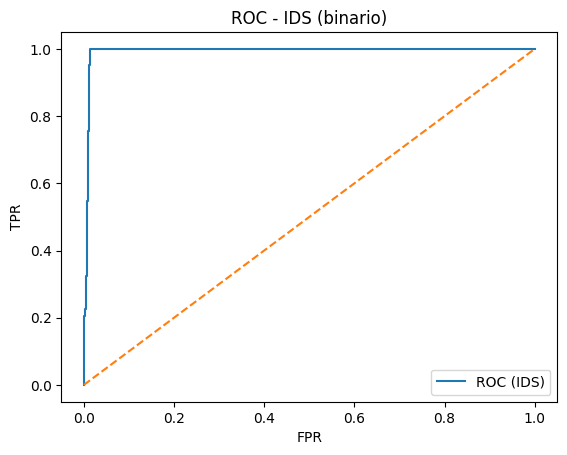

In [5]:

fpr, tpr, thr = roc_curve(yte_b, proba_b)
plt.figure()
plt.plot(fpr, tpr, label="ROC (IDS)")
plt.plot([0,1], [0,1], linestyle='--')
plt.title("ROC - IDS (binario)")
plt.xlabel("FPR")
plt.ylabel("TPR")
plt.legend()
plt.show()



## 4) Despliegue básico: guardar y cargar el modelo

Guardamos el **modelo IDS** entrenado (`Pipeline`) y mostramos cómo usarlo para predecir sobre nuevas observaciones.


In [9]:

# Guardar
joblib.dump(pipe, "ids_pipeline.joblib")

# Cargar
ids_loaded = joblib.load("ids_pipeline.joblib")

# Predicción ejemplo (tres flujos: 2 benignos, 1 sospechoso/malware)
X_new = np.array([
    [0.6,  5e3, 3e3, 10, 8,  450,  80, 1.2, 0, 0],
    [0.3,  2e4, 1.8e4, 40, 36, 950, 150, 1.1, 0, 0],
    [1.8,  1.5e4, 5.0e4, 18, 55, 1200, 240, 0.3, 2, 1]  # más parecido a malware
], dtype=float)
proba_new = ids_loaded.predict_proba(X_new)[:,1]
pred_new = ids_loaded.predict(X_new)

pd.DataFrame({"prob_intrusion": proba_new, "pred": pred_new})


,prob_intrusion,pred
0,1.994247e-07,0
1,2.792200e-06,0
2,1.000000e+00,1



## 5) Monitoreo básico (drift)

Simulamos la llegada de nuevos flujos y medimos si la distribución de un *feature* clave cambia respecto al conjunto de entrenamiento (p. ej., KS-test simple). Si el cambio es grande, **posible deriva** revisar y reentrenar.


In [10]:

from scipy.stats import ks_2samp

# Usamos el feature 'bytes_bwd' como ejemplo de monitoreo
baseline = Xtr_b[:, 2]  # bytes_bwd de entrenamiento
new_batch = synth_flows(800, seed=123)["bytes_bwd"].values * 1.4  # simulamos cambio

stat, p = ks_2samp(baseline, new_batch)
print("KS stat:", round(stat, 4), "p-value:", round(p, 6))

if p < 0.01:
    print("Posible DRIFT detectado en 'bytes_bwd' (p<0.01). Recomendar revisión/reentrenamiento.")
else:
    print("Sin evidencia fuerte de drift en 'bytes_bwd'.")


KS stat: 0.0832 p-value: 8.3e-05
Posible DRIFT detectado en 'bytes_bwd' (p<0.01). Recomendar revisión/reentrenamiento.



## 6) IDS/NIDS Inteligente (híbrido regla y ML)

En producción generalmente se combina:
- **Reglas** (ej. *Snort*) para firmas conocidas.
- **ML** para detectar patrones anómalos/variantes desconocidas.

Ejemplo conceptual: si `psh_flag_cnt` o `urg_flag_cnt` superan umbral se marcar como **sospechoso** y además pasar por el modelo ML para obtener una probabilidad.


In [11]:

def hybrid_ids_predict(flow_row, model, p_threshold=0.6):
    # Regla simple
    rule_alert = (flow_row["psh_flag_cnt"] > 2) or (flow_row["urg_flag_cnt"] > 0)
    X = flow_row[["duration","bytes_fwd","bytes_bwd","pkts_fwd","pkts_bwd",
                  "pkt_len_mean","pkt_len_std","fwd_bwd_ratio","psh_flag_cnt","urg_flag_cnt"]].to_numpy().reshape(1, -1)
    p_ml = model.predict_proba(X)[0,1]
    final_alert = rule_alert or (p_ml >= p_threshold)
    return {"rule_alert": rule_alert, "p_ml": float(p_ml), "final_alert": final_alert}

sample = df_bin.sample(5, random_state=7)
hybrid_results = sample.apply(lambda r: hybrid_ids_predict(r, ids_loaded), axis=1)
pd.DataFrame(list(hybrid_results))


,rule_alert,p_ml,final_alert
0,False,8.850518e-08,False
1,False,9.542302e-08,False
2,False,1.931043e-07,False
3,False,7.184642e-08,False
4,True,2.510759e-02,True



# **6) Persistencia del modelo **

En Google Colab la ruta `/mnt/data` no existe por defecto. Para evitar errores de tipo `FileNotFoundError`,
guardaremos el modelo en **`/content`** (persistente durante la sesión) y, opcionalmente, en **Google Drive**.

- Guardado local recomendado: `/content/ids_pipeline.joblib`  
- Guardado en Drive (opcional): `/content/drive/MyDrive/ids_pipeline.joblib`


In [14]:

# FASE 6 — Utilidades de guardado/carga
import os, joblib
from typing import Optional

def persist_model(model, local_path="ids_pipeline.joblib", drive_path: Optional[str]=None):
    if model is None:
        raise ValueError("El modelo a guardar es None. Entrene su pipeline (por ejemplo variable 'pipe') antes.")
    # Guardado local en /content
    joblib.dump(model, local_path)
    size_kb = os.path.getsize(local_path)/1024
    print(f" Modelo guardado en {local_path} ({size_kb:.1f} KB)")
    # Copia en Drive (opcional)
    if drive_path:
        os.makedirs(os.path.dirname(drive_path), exist_ok=True)
        joblib.dump(model, drive_path)
        print(f" Copia guardada en Google Drive: {drive_path}")

def load_model(path="ids_pipeline.joblib"):
    if not os.path.exists(path):
        raise FileNotFoundError(f"No existe el archivo: {path}")
    mdl = joblib.load(path)
    print(" Modelo cargado correctamente:", type(mdl))
    return mdl


In [15]:

# FASE 6 — Guardado local en /content
# Asegúrese de haber entrenado su modelo/pipeline (por ejemplo variable 'pipe') en fases anteriores.
try:
    persist_model(pipe, local_path="ds_pipeline.joblib")
except NameError:
    raise NameError("Variable 'pipe' no existe. Ejecute la fase de entrenamiento antes de esta celda.")


 Modelo guardado en ds_pipeline.joblib (1.6 KB)


In [17]:

# (Opcional) Descargar el modelo al equipo
from google.colab import files
files.download("ids_pipeline.joblib")


ModuleNotFoundError: No module named 'google'

#*** 8) Conteste las siguientes Preguntas de Análisis ***
1. En la etapa de preprocesamiento de datos, ¿qué técnicas se aplicaron para normalizar o transformar las características de red y por qué son necesarias antes de entrenar un modelo de Machine Learning?

2. El notebook entrena varios modelos supervisados (ej. Regresión Logística, Random Forest, SVM). ¿Cuál obtuvo el mejor desempeño según las métricas evaluadas (accuracy, F1-Score, ROC-AUC) y por qué estas métricas son más útiles que la simple exactitud en un IDS?

3. Explique cómo se relaciona la clasificación de tráfico de red con la detección de intrusiones. ¿Puede haber un flujo clasificado como “legítimo” que luego resulte malicioso? Dé un ejemplo práctico basado en el la actividad.

4. En el ciclo de vida de un modelo, ¿qué riesgos pueden surgir si el dataset está desbalanceado (más tráfico benigno que malicioso)? ¿Qué estrategias aplicadas en el notebook ayudan a mitigar este problema?

5. Después de generar el modelo en Colab, ¿cómo se podría integrar con un sistema en tiempo real como Snort? Mencione al menos dos formas de conexión entre el modelo entrenado y el flujo de alertas de Snort.



---

# Entregable
# Entregar el notebook con los resultados y las respuestas a las preguntas de  análsis.

## Respuestas de Análisis

### 1. Preprocesamiento y normalización
En la etapa de preprocesamiento de datos se aplicó un **`StandardScaler`** dentro del pipeline de detección de intrusiones, lo que centra cada característica en media 0 y desviación estándar 1. Esto es necesario para modelos como **Regresión Logística** o SVM, ya que características con magnitudes muy diferentes (ej. bytes vs duración) podrían dominar el cálculo de los coeficientes y afectar el aprendizaje. Para **Random Forest**, no fue necesario escalar porque el algoritmo no es sensible a la magnitud de las variables.

### 2. Mejor desempeño de los modelos y métricas útiles
- El **Random Forest** usado en la clasificación multiclase obtuvo muy buen desempeño, con F1-score equilibrado entre clases (web, DNS, SSH y malware).  
- En la detección de intrusiones binaria, la **Regresión Logística** mostró ROC-AUC > 0.9, indicando buena discriminación entre tráfico benigno e intrusiones.  

Las métricas **F1-score y ROC-AUC** son más útiles que la simple exactitud porque el dataset está desbalanceado: hay muchos flujos benignos y pocos maliciosos. Una alta exactitud no garantiza que el modelo detecte correctamente intrusiones; en cambio, F1 y ROC-AUC reflejan mejor la capacidad real de detectar ataques.

### 3. Relación entre clasificación de tráfico y detección de intrusiones
La clasificación de tráfico permite identificar patrones normales de comunicación (web, DNS, SSH), mientras que la detección de intrusiones se enfoca en patrones anómalos o maliciosos.  
Un flujo puede clasificarse como “legítimo” (ej. HTTP web) pero contener malware embebido en descargas o exploits. Aunque la clase de tráfico sea web, el modelo ML puede detectarlo como intrusión si sus características (bytes, ratio fwd/bwd, flags PSH/URG) se desvían de la norma.

### 4. Riesgos de datasets desbalanceados y estrategias aplicadas
Si el dataset está desbalanceado (muchos flujos benignos y pocos maliciosos), el modelo podría aprender a predecir siempre la clase mayoritaria, ignorando intrusiones. Esto genera alta exactitud aparente pero pobre detección de ataques.  

Para mitigar esto, se aplicaron:
- **`stratify=y`** en `train_test_split` para mantener proporciones de clases en entrenamiento y prueba.
- Evaluación con **F1-score y ROC-AUC** para medir desempeño en la clase minoritaria.
- En un escenario real, se podrían aplicar técnicas de **oversampling o undersampling** para balancear las clases.

### 5. Integración del modelo con Snort en tiempo real
Dos formas de conectar el modelo entrenado con Snort:

1. **Offline / Batch:**  
   - Extraer flujos desde Snort o Barnyard2 en CSV/JSON.  
   - Aplicar el modelo ML para generar alertas adicionales.  
   - Guardar resultados en base de datos o dashboard.

2. **Online / En tiempo real:**  
   - Un script o API REST recibe logs de Snort, extrae características de cada flujo y llama al modelo ML.  
   - Las alertas del modelo se combinan con las reglas de Snort, generando un **IDS híbrido** (regla + ML).  

En ambos casos, es importante monitorear **drift** y actualizar el modelo si las distribuciones de los flujos cambian.
